# Sentiment Analysis Data Storytelling

### Import necessary libraries

In [1]:
# Dataframe
import pandas as pd

# Array
import numpy as np

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Datetime
from datetime import datetime

# text preprocessing
import spacy
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata
tokenizer = ToktokTokenizer()
nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
from sklearn.feature_extraction.text import CountVectorizer

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guzel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Reading the Cleaned Dataset

In [2]:
# Read the file
df2 = pd.read_csv('C:/Users/guzel/Documents/amazon_beauty_products/cleaned_dataset.csv')

### Inspecting the dataset

In [3]:
# Sample observations
df2.sample(3)

,customer,product,review_text,rating_class,year,clean_text,tokens
8053,A27D0VRNOOUNRR,B0073P01RC,good primer/SPF combo but expensive and not fo...,good,2012,good primer spf combo expensive not dry skin c...,"['good', 'primer', 'spf', 'combo', 'expensive'..."
6722,A1AHG23GNXBYYY,B0061YSLKA,"stylish animal print Zebra print, yey! I truly...",good,2012,stylish animal print zebra print yey truly lov...,"['stylish', 'animal', 'print', 'zebra', 'print..."
14931,A1WKQ94M45D8MG,B00AO4E9E0,"Soft and smooth... I love trying new shampoos,...",good,2013,soft smooth love try new shampoo though use tr...,"['soft', 'smooth', 'love', 'try', 'new', 'sham..."


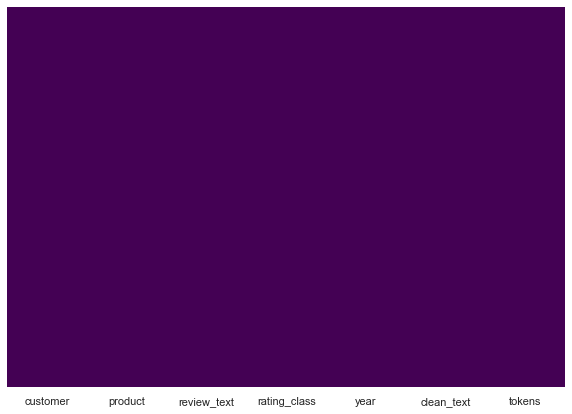

In [4]:
# There is no missing value in the dataset
plt.figure(figsize = (10,7))
sns.set()
_ = sns.heatmap(df2.isnull(), yticklabels=False, cbar = False, cmap = 'viridis')

In [5]:
# Basic Information about the Data Set
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24509 entries, 0 to 24508
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   customer      24509 non-null  object
 1   product       24509 non-null  object
 2   review_text   24509 non-null  object
 3   rating_class  24509 non-null  object
 4   year          24509 non-null  int64 
 5   clean_text    24509 non-null  object
 6   tokens        24509 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.3+ MB


# Exploratory Data Analysis

# Target Variable

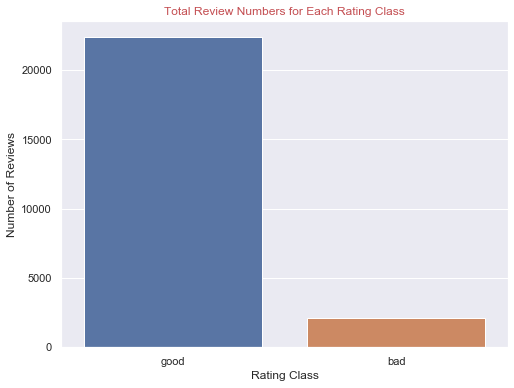

good    22425
bad      2084
Name: rating_class, dtype: int64

In [6]:
# Total numbers of ratings in the beauty product reviews
plt.figure(figsize = (8,6))
sns.countplot(df2['rating_class'])
plt.title('Total Review Numbers for Each Rating Class', color='r')
plt.xlabel('Rating Class')
plt.ylabel('Number of Reviews')
plt.show()

# Customer totals for each rating class
df2['rating_class'].value_counts()

* Customers wrote reviews and gave ratings, which ranged between 1 to 5, for each beauty product they bought in the Amazon online market between 04-13-2005 and 07-23-2014. In overall, customers were seemed to be averagely satisfied with the products which they experienced. 


* We diminished those 5 rating categories into two categories such as 'good' and 'bad' in order to implement a sentiment analysis on their reviews. According to those reviews, 91.5% of them (22425) are classified as good, whereas 8.5% of them (2084) are bad.

# Features

## 1. Year Feature

Let's see how the rating classes change for each year in a table and graph.

<Figure size 864x576 with 0 Axes>

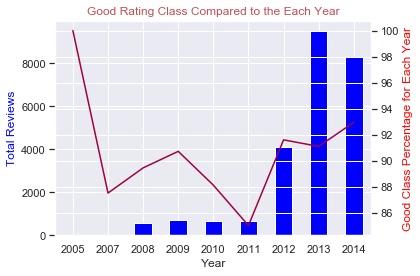

In [7]:
# Create a graph for each rating class to compare within the years

df2['rating_class_num'] = df2['rating_class'].map({'good': 1, 'bad': 0})

feature = df2.groupby('year').agg({'rating_class_num':['size', 'sum', 'mean']})
feature.columns = [' '.join(col).strip() for col in feature.columns.values]
feature = feature.reset_index()
feature['rating_class_num mean'] = feature['rating_class_num mean']*100
feature.columns = ['Year', 'Total Reviews', 'Relevant Rating Number', 
                    '% of Relevant Rating Number in This Year'] 

plt.figure(figsize = (12,8))
fig0, ax1 = plt.subplots()
ax2 = ax1.twinx()
feature.set_index(feature['Year'], drop=True, inplace=True)
feature["Total Reviews"].plot(kind = 'bar', stacked = True, ax = ax1, colormap = 'winter', rot=0)
feature['% of Relevant Rating Number in This Year'].plot(use_index = False, 
                                                         kind = 'line', ax = ax2, colormap='Spectral')   

plt.title('Good Rating Class Compared to the Each Year', color='r')
ax1.set_xlabel('Year')
ax1.yaxis.label.set_color('blue')
ax1.set_ylabel("Total Reviews")
ax2.set_ylabel("Good Class Percentage for Each Year")
ax2.yaxis.label.set_color('red')
plt.tight_layout()
plt.show()  

In [8]:
# Create a dataframe which shows the relationship between review numbers and rating classes for each year

df2['rating_class_num'] = df2['rating_class'].map({'good': 1, 'bad': 0})
    
feature = df2.groupby('year').agg({'rating_class_num':['size', 'sum', 'mean']})
feature.columns = [' '.join(col).strip() for col in feature.columns.values]
feature = feature.reset_index()
feature['rating_class_num mean'] = feature['rating_class_num mean']*100
feature.columns = ['Year', 'Total Reviews', 'Relevant Rating Number', 
                       '% of Relevant Rating Number in This Year'] 
feature['% of Relevant Rating in the Total'] = (feature['Relevant Rating Number'] / 22425)*100
        
feature

,Year,Total Reviews,Relevant Rating Number,% of Relevant Rating Number in This Year,% of Relevant Rating in the Total
0,2005,1,1,100.000000,0.004459
1,2007,32,28,87.500000,0.124861
2,2008,549,491,89.435337,2.189521
3,2009,721,654,90.707351,2.916388
4,2010,656,578,88.109756,2.577480
5,2011,680,578,85.000000,2.577480
6,2012,4079,3736,91.591076,16.659978
7,2013,9490,8644,91.085353,38.546265
8,2014,8301,7715,92.940610,34.403567


After 2012, good ratings' percentage is progressing over 90%. Before 2012, only 2009 also shows a slightly rapid increase in good ratings from 87.5% to 90.7%. Besides those, 2011 has the lowest good ratings with 85% overall. As it might be seen in the graph, the overall good rating is progressing between 85% and 93% in beauty products.

## 2. Customer Feature

**Unique Customers**

In [9]:
# How many unique customers do we have in the dataset?
print('Number of unique customers: {}'.format(len(df2['customer'].unique())))

Number of unique customers: 1340


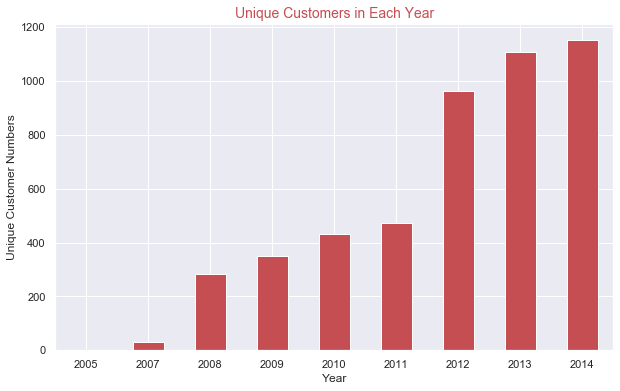

year
2005       1
2007      31
2008     283
2009     351
2010     433
2011     474
2012     964
2013    1108
2014    1154
Name: customer, dtype: int64


In [10]:
# How many unique customers in each year?
unique_cust = df2.groupby('year')['customer'].nunique()

# Plot unique customer numbers in each year
plt.figure(figsize = (10,6))
unique_cust.plot(kind='bar', rot = 0, color='r')
plt.title('Unique Customers in Each Year', color='r', size = 14)
plt.xlabel('Year')
plt.ylabel('Unique Customer Numbers')
plt.show()

# Print unique customer numbers in each year
print(unique_cust)

**How many unique customers do we have in each rating class?**

In [11]:
# unique customers for each "rating class"
a = list(df2.groupby(['rating_class'])['customer'].unique())  

# number of customers
a2 = [len(a[0]),len(a[1])] 

# number of reviews for each "rating class"
b = list(df2['rating_class'].value_counts())              

uniq_cust_rate = pd.DataFrame({'rating_class': ['bad', 'good'],
                               'number_of_customers': a2,
                               'number_of_reviews': sorted(b)})
print(uniq_cust_rate)

  rating_class  number_of_customers  number_of_reviews
0          bad                  747               2084
1         good                 1340              22425


We have total 1340 unique customers who gave good reviews and 747 customers who gave bad reviews in the dataset. As it may be observed in the chart and table, the number of unique customers for each year has increased with the progress of the year.

## 3. Product Feature¶

**The Number of Unique Products**

In [12]:
# Print number of unique beauty products in the dataset
print('Number of unique beauty products: {}'.format(len(df2['product'].unique())))

Number of unique beauty products: 733


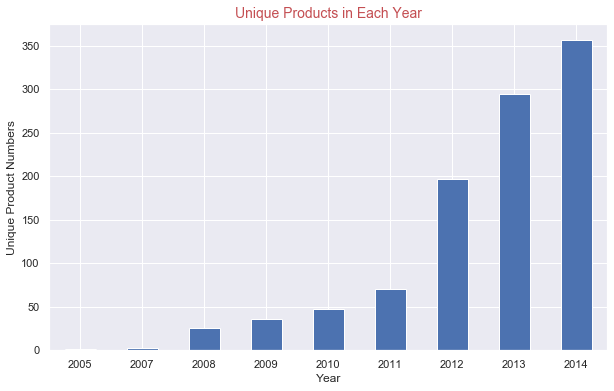

year
2005      1
2007      3
2008     26
2009     36
2010     47
2011     71
2012    197
2013    294
2014    357
Name: product, dtype: int64


In [13]:
# How many unique products in each year?
unique_prod = df2.groupby('year')['product'].nunique()

# Plot unique product numbers in each year
plt.figure(figsize = (10,6))
unique_prod.plot(kind='bar', color = 'b', rot =0)
plt.title('Unique Products in Each Year', color = 'r', size = 14)
plt.xlabel('Year')
plt.ylabel('Unique Product Numbers')
plt.show()

# Print unique product numbers in each year
print(unique_prod)

We have total 733 unique products in the dataset which belongs to year between 2005 and 2014. As it may be observed in the chart and table, the number of unique products for each year has increased with the progress of the year.

# 4. Review Length Feature

In [14]:
# Function for creating a column to see the length of the review text
def length(text):
    length = len([w for w in nltk.word_tokenize(text)])
    return length

# Apply length function to create review length feature
df2['review_length'] = df2['review_text'].apply(length)
df2.head()

,customer,product,review_text,rating_class,year,clean_text,tokens,rating_class_num,review_length
0,A6VPK7X53QNAQ,B0000CC64W,If I had to choose only one product to take ca...,good,2009,choose one product take care face rest life wo...,"['choose', 'one', 'product', 'take', 'care', '...",1,252
1,A3CHMHGSJSQ02J,B0000CC64W,Makes my skin lovely and smooth As a woman nea...,good,2013,make skin lovely smooth woman near need help g...,"['make', 'skin', 'lovely', 'smooth', 'woman', ...",1,75
2,A1V1EP514B5H7Y,B0000CC64W,Works well at a reasonable price I've used thi...,good,2011,work well reasonable price use regenerating se...,"['work', 'well', 'reasonable', 'price', 'use',...",1,76
3,A1X2LENOF84LCQ,B0000CC64W,This does work ladies I have tried so many pro...,good,2005,work lady try many product totally disappointe...,"['work', 'lady', 'try', 'many', 'product', 'to...",1,80
4,A2PATWWZAXHQYA,B0000CC64W,Did not like the feel/texture of this serum I ...,bad,2013,not like feel texture serum love oil olay prim...,"['not', 'like', 'feel', 'texture', 'serum', 'l...",0,98


In [15]:
# Create review length bin feature
df2['review_length_bin'] = pd.cut(df2['review_length'], np.arange(0,500,50))
df2.head()

,customer,product,review_text,rating_class,year,clean_text,tokens,rating_class_num,review_length,review_length_bin
0,A6VPK7X53QNAQ,B0000CC64W,If I had to choose only one product to take ca...,good,2009,choose one product take care face rest life wo...,"['choose', 'one', 'product', 'take', 'care', '...",1,252,"(250, 300]"
1,A3CHMHGSJSQ02J,B0000CC64W,Makes my skin lovely and smooth As a woman nea...,good,2013,make skin lovely smooth woman near need help g...,"['make', 'skin', 'lovely', 'smooth', 'woman', ...",1,75,"(50, 100]"
2,A1V1EP514B5H7Y,B0000CC64W,Works well at a reasonable price I've used thi...,good,2011,work well reasonable price use regenerating se...,"['work', 'well', 'reasonable', 'price', 'use',...",1,76,"(50, 100]"
3,A1X2LENOF84LCQ,B0000CC64W,This does work ladies I have tried so many pro...,good,2005,work lady try many product totally disappointe...,"['work', 'lady', 'try', 'many', 'product', 'to...",1,80,"(50, 100]"
4,A2PATWWZAXHQYA,B0000CC64W,Did not like the feel/texture of this serum I ...,bad,2013,not like feel texture serum love oil olay prim...,"['not', 'like', 'feel', 'texture', 'serum', 'l...",0,98,"(50, 100]"


In [16]:
# Good rating percentages for each length bin with 50's
per_pos_length = df2.groupby(['review_length_bin'])['rating_class_num'].mean()
df2['review_length_bin'] = df2.review_length_bin.astype(str)

per_pos_length = per_pos_length*100
per_pos_length

review_length_bin
(0, 50]       96.436285
(50, 100]     93.055754
(100, 150]    90.954505
(150, 200]    89.878319
(200, 250]    89.059501
(250, 300]    88.421053
(300, 350]    87.612903
(350, 400]    89.062500
(400, 450]    88.349515
Name: rating_class_num, dtype: float64

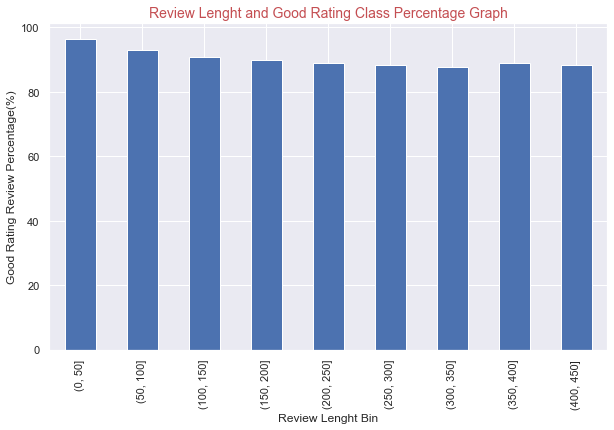

In [17]:
# Plot the graph for good rating class percentage and review length bin
plt.figure(figsize = (10,6))
per_pos_length.plot(kind='bar')
plt.title('Review Lenght and Good Rating Class Percentage Graph', color = 'r', size = 14)
plt.xlabel('Review Lenght Bin')
plt.ylabel('Good Rating Review Percentage(%)')
plt.show()

As it might be seen the graph, the highest percentage of good rating reviews lies between 0-50 words with 96.4% whereas lowest percentage of good rating reviews lies between 400-450 words with 88.3%. As the review length extends, the good rating tends to decrease slightly. The difference between good rating review percentage with shortest and longest of review length bin is 8.1%. Insightfully, the customers who have complains about the products are more willingly to write longer reviews than other customers who are satisfied with company's products. 

**Correlation Between Numeric Variables**

<Figure size 432x288 with 0 Axes>

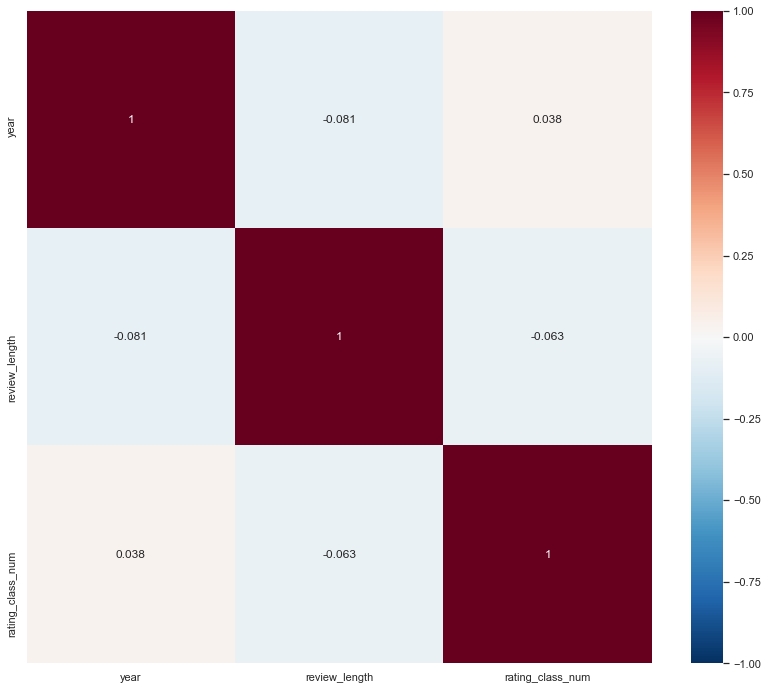

In [18]:
# Plotting correlation matrix between numeric variables
corr = df2[['year','review_length', 'rating_class_num']].corr(method="pearson")

# display(correlation)
fig3 = plt.figure()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(corr, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

There is no strong correlation between any two numeric variables. 

# 5. Text Review Feature

In [19]:
# Create a new data frame with clean text and rating class
df = df2[["clean_text", "rating_class_num"]]
df.head(10)

,clean_text,rating_class_num
0,choose one product take care face rest life wo...,1
1,make skin lovely smooth woman near need help g...,1
2,work well reasonable price use regenerating se...,1
3,work lady try many product totally disappointe...,1
4,not like feel texture serum love oil olay prim...,0
5,olay fine olay regenerist daily regenerating s...,1
6,nice product bit greasy olay regenerist daily ...,1
7,clean easy purchase fragrance free hate face s...,1
8,notice difference immediately first thing noti...,1
9,surprising start new skin regimen recently ret...,1


In [20]:
# Initialize the countervectorizer
countVec = CountVectorizer(binary=True)

In [21]:
# Fit the 'clean_text' to countvectorizer
countVec.fit(df["clean_text"])

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [22]:
# Transform the matriz
transformed_matrix = countVec.transform(df["clean_text"])

In [23]:
# Convert matrix to array
transformed_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [24]:
# Extracting the feature names
names = countVec.get_feature_names()

In [25]:
# Adding a 'rating' column from previous dataframe's rating value
df3 = pd.DataFrame(transformed_matrix.toarray(), columns=names)
df3['rating'] = df['rating_class_num']

In [26]:
# Create lists for forming a dataframe summary
feature_names = []
avg_ratings = [] 
rating_counts = []
for name in names:
    if name != 'rating':    
        avg_rating = df3[df3[name]== 1]['rating'].mean()
        rating_count = df3[df3[name]== 1]['rating'].count()
        feature_names.append(name)
        avg_ratings.append(avg_rating)
        rating_counts.append(rating_count)  
    else:
        pass

In [27]:
# Create a new dataframe from words, average ratings, and rating counts
df_summary = pd.DataFrame({'feature_name':feature_names, 'avg_rating': avg_ratings, 'rating_count':rating_counts})

In [28]:
# Let's see the new dataframe
df_summary

,feature_name,avg_rating,rating_count
0,______________________________________________...,0.000000,1
1,_____________________________________________i,0.000000,1
2,________________________________________product,1.000000,1
3,_____________________addendum,1.000000,1
4,aa,0.764706,34
...,...,...,...
25407,zoomlash,1.000000,1
25408,zwilling,0.800000,5
25409,zync,1.000000,1
25410,zz,1.000000,1


**Good rating words**

In [29]:
# Words that are commonly used in the reviews which have good ratings
df_good = df_summary.query("rating_count > 100").sort_values(by='avg_rating', ascending=False)[:100]

In [30]:
df_good

,feature_name,avg_rating,rating_count
18846,rosehip,1.000000,105
377,adovia,1.000000,244
19763,shany,1.000000,192
11208,instanatural,0.994565,184
7603,express,0.991870,123
...,...,...,...
24048,uv,0.963964,111
9494,great,0.963805,8841
18540,retain,0.963636,110
20795,spike,0.963504,137


In [31]:
wc_good = dict(zip(df_good['feature_name'].tolist(), df_good['avg_rating'].tolist()))

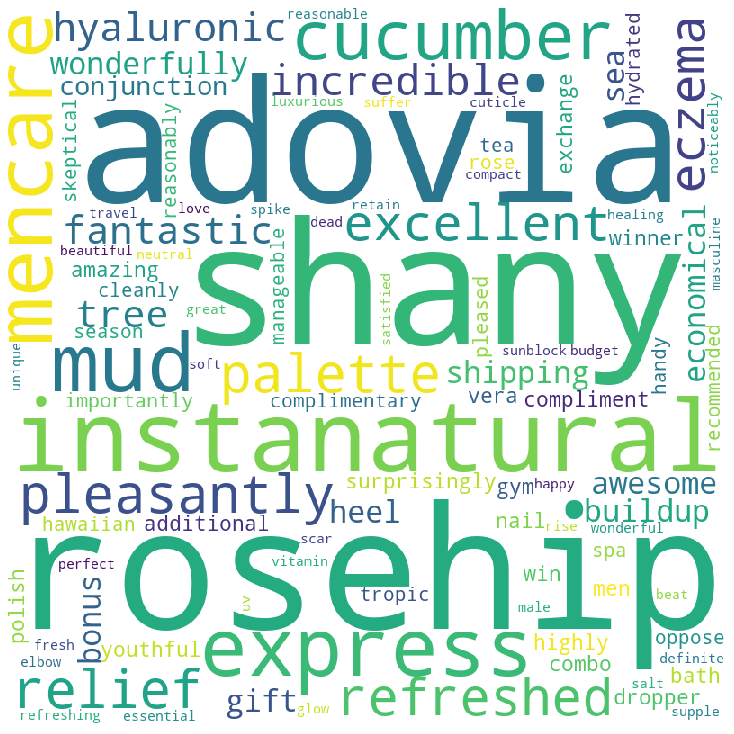

In [32]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(wc_good)
 
# plot the WordCloud image                       
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Fixing the rating count value is above 100, the most common 50 words which belong to good rating class are shown in the table above. Each of these words define which products what kind of good impression have on the customers. For example, ‘mencare’ and ‘men’ words tell male beauty products are more appreciated in the reviews. On the other hand, ‘eczema’, and ‘scar’ tell some beauty products are praised for covering them. ‘economical’ and ‘shipping’ words might give the insight that products are accepted as reasonably priced and conveniently shipped to the customers. 

**Bad rating words**

In [33]:
# Words that are commonly used in the reviews which have bad ratings
df_bad = df_summary.query("rating_count > 100").sort_values(by= 'avg_rating', ascending=True)[:100]

In [34]:
df_bad

,feature_name,avg_rating,rating_count
20652,sorry,0.481818,110
23560,unfortunately,0.536585,369
6117,disappointed,0.538095,210
7786,fail,0.582524,103
1445,attempt,0.626168,107
...,...,...,...
25172,wrap,0.821168,274
3565,chin,0.821192,151
22013,taste,0.822695,141
7446,except,0.822695,282


In [35]:
wc_bad = dict(zip(df_bad['feature_name'].tolist(), df_bad['avg_rating'].tolist()))

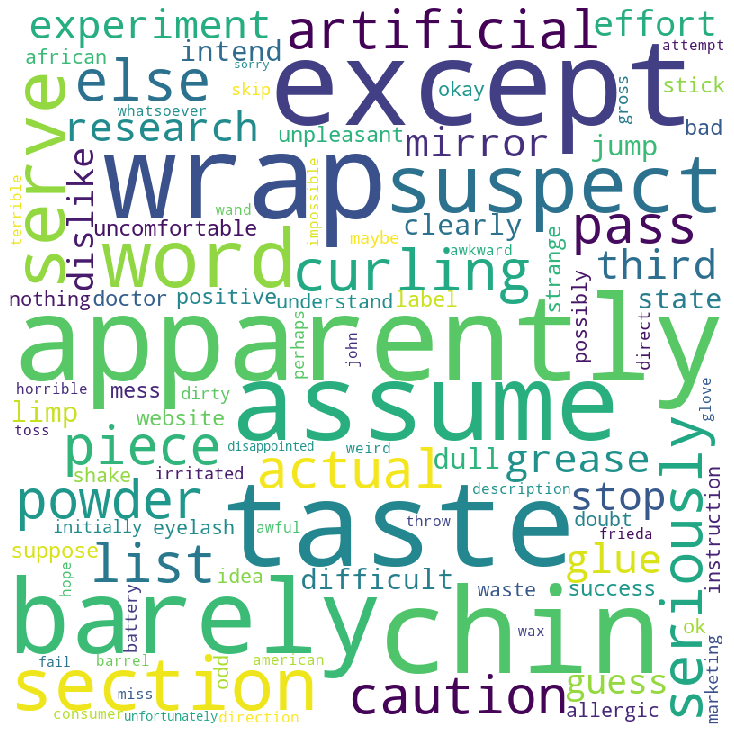

In [36]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(wc_bad)
 
# plot the WordCloud image                       
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Same standards as above, the most common 50 words which belong to bad rating class are shown in this table. Likewise, in good ratings, each of these words define which products what kind of bad impression have on the customers. For example, ‘wax’ products have mostly used to complain. ‘description’ word gives insight that the product’s usage is not clearly depicted in the description or beauty product has side effects which the description fails to explain. 

**Controversial Cases:**

The controversial case such as "I was expecting better - negative meaning" or "it was better than my expectation - positive meaning " will be handled in the modelling section via using deep learning technique (Keras with Word2Vec).

# Exploratory Data Analysis Summary:

*  We diminished those 5 rating categories into two categories like 91.5% of them (22425) are classified as good, whereas 8.5% of them (2084) are bad.

*  After 2012, good ratings' percentage is progressing over 90%. Before 2012, only 2009 also shows a slightly rapid increase in good ratings from 87.5% to 90.7%. Besides those, 2011 has the lowest good ratings with 85% overall. As it might be seen in the graph, the overall good rating is progressing between 85% and 93% in beauty products.

*  If we compare the review length and good/bad categories, the highest percentage of good rating reviews lies between 0-50 bin with 96.4% whereas lowest percentage of good rating reviews lies between 400-450 bin with 88.3%. As the review length extends, the good rating tends to decrease slightly. The difference between good rating review percentage with shortest and longest of review length bin is 8.1%. Insightfully, the customers who have complains about the products are more willingly to write longer reviews than other customers who are satisfied with company's products.

*  There is no strong correlation between any two numeric variables.

*  The most common words used to reflect good and bad sentiments are shown above and we may extract insights from each categories' words.

*  The controversial case such as "I was expecting better - negative meaning" or "it was better than my expectation - positive meaning " will be handled in the modelling section via using deep learning technique (Keras with Word2Vec).